### Baseline y ejemplo de lectura y escritura de archivo para concurso kaggle

Librerias

In [1]:
import os
import re
import csv
import os
from tqdm import tqdm
from nltk import RegexpTokenizer
from nltk import TweetTokenizer
import xml.etree.ElementTree as ET

Lectura de datos

In [2]:
def obtener_texto_xml(ruta_archivo):
    '''
    Obtiene el texto de un archivo XML.
    '''
    tree = ET.parse(ruta_archivo)
    root = tree.getroot()
    texto = "".join(root.itertext())  
    return texto

def get_texts_from_files(path_corpus, filename):
    file_path = os.path.join(path_corpus, filename)
    with open(file_path, 'r') as file: 
        contenido = file.read().split()

        tr_txt = []
        tr_y_gen = []
        tr_y_nat = []
        for label in contenido:
            name, gen, nat = label.split(':::')
            tr_txt.append(obtener_texto_xml(path_corpus + name + '.xml'))
            tr_y_gen.append(gen)
            tr_y_nat.append(nat)       
    return tr_txt, tr_y_gen, tr_y_nat

In [3]:
path = "../../corpus/examen2/"

tr_txt, tr_y_gen, tr_y_nat = get_texts_from_files(path + 'es_train/', "truth.txt")
val_txt, val_y_gen, val_y_nat = get_texts_from_files(path + 'es_val/', "truth.txt")
test_txt, _, __ = get_texts_from_files(path + 'es_test/', "truth_order.txt")

Convertir etiquetas string a enteros

In [4]:
from sklearn.preprocessing import LabelEncoder

enc_gen = LabelEncoder()
enc_nat = LabelEncoder()

tr_y_gen = enc_gen.fit_transform(tr_y_gen)
tr_y_nat = enc_nat.fit_transform(tr_y_nat)

val_y_gen = enc_gen.fit_transform(val_y_gen)
val_y_nat = enc_nat.fit_transform(val_y_nat)

Visualización de etiquetas

Counter({2: 480, 3: 480, 0: 480, 5: 480, 6: 480, 4: 480, 1: 480})


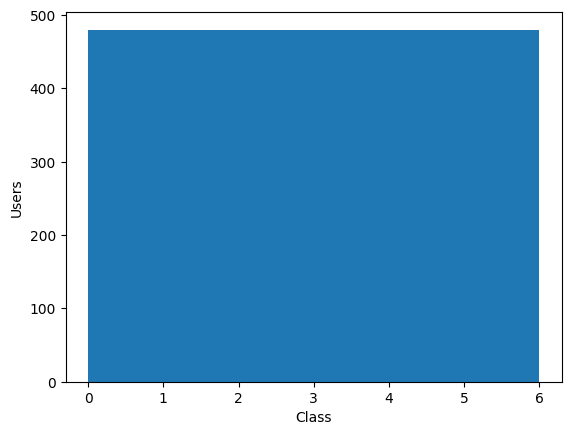

Counter({0: 1680, 1: 1680})


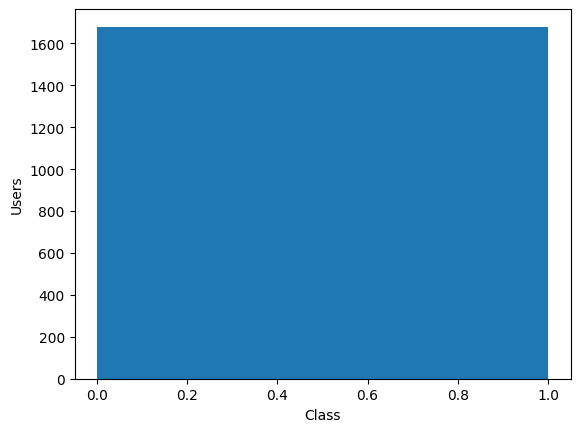

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

print(Counter(tr_y_nat))
plt.hist(tr_y_nat, bins=len(set(tr_y_nat)))
plt.ylabel('Users')
plt.xlabel('Class')
plt.show()

print(Counter(tr_y_gen))
plt.hist(tr_y_gen, bins=len(set(tr_y_gen)))
plt.ylabel('Users')
plt.xlabel('Class')
plt.show()

Limpiamos un poco los tuits

In [6]:
from nltk import RegexpTokenizer
from nltk import TweetTokenizer
import re

def tok(doc):
    tokenizer = TweetTokenizer()
    return tokenizer.tokenize(doc)

def clean_tweets(doc):
    doc_tok = [tok(x) for x in doc]
    for k, tuit_tok in enumerate(doc_tok):
        for i in range(len(tuit_tok)):
            # Reemplazar @xxxxxx por @usuario
            if tuit_tok[i][0] == '@':
                tuit_tok[i] = '@usuario'
            # Eliminar https://...
            if tuit_tok[i][:4] == 'http':
                tuit_tok[i] = ''
        doc_tok[k] = tuit_tok
    return [' '.join(x) for x in doc_tok]
    

print(tr_txt[0])
tr_txt = clean_tweets(tr_txt)
val_txt = clean_tweets(val_txt)
test_txt = clean_tweets(test_txt)
print(tr_txt[0])


	
		Mientras ustedes pasean, yo veo bonitos atardeceres en la tierra. https://t.co/sZgaYGLAkb
		@bbluman evidentemente su discapacidad es cognitiva.
		@mhernandezarand qué foto tan bella!! Y el perro 😍😍
		@palaciotamayo qué triste... Es una pérdida muy grande para la ciudad.
		Mi TL está alineado. https://t.co/fXLKKO8mmH
		Y no devolver lo robado. https://t.co/rGJ7qwNP06
		Léase con sarcasmo https://t.co/upeFhZY930
		Cómo es que hay gente que pasa 5 años en una universidad pa terminar siendo un total pendejo!
		A propósito de la desnutrición de los niños colombianos. Muy recomendado. https://t.co/IQ0ibRrmSC
		La ISS estará visible desde , el viernes, 20 de enero a las 20:00:07
Comenzando en el SO (233°)
y terminando en el OSO (246°) a las 20:01:37
		Uno de mis propósitos para 2017 es no criticar tanto, por eso no voy a decir que Johnny Depp está feo y parece borracho.
		La gente que gana premios siempre dice que de niños la mamá le daban consejos rebeldes. A mi me decía que aprendiera

### Entrenamos una bolsa de n-gramas y evaluamos primero con la etiqueta de GÉNERO

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import scipy.sparse as sp
from time import time
import numpy as np

def normalize(f):
    #f = [x.lower() for x in f]
    #f = [x.replace("\\n"," ") for x in f]        
    #f = [x.replace("\\t"," ") for x in f]        
    #f = [x.replace("\\xa0"," ") for x in f]
    #f = [x.replace("\\xc2"," ") for x in f]
    
    #f = [re.subn(" [*$%&#@][*$%&#@]+"," xexp ", x)[0].strip() for x in f]
    #f = [re.subn(" [0-9]+ "," DD ", x)[0].strip() for x in f]
    #f = [re.subn("<\S*>","", x)[0].strip() for x in f]
    return f

def ngrams(data, labels, ntrain, mn=1, mx=1, nm=500, binary = False, donorm = False, stopwords = False, verbose = True, analyzer_char = False):
    f = data
    if donorm:
        f = normalize(f)
    
    ftrain = f[:ntrain]
    ftest  = f[ntrain:]
    y_train = labels[:ntrain]
    
    t0 = time()
    analyzer_type = 'word'
    if analyzer_char:
        analyzer_type = 'char'
        
    if binary:
        vectorizer = CountVectorizer(max_n=mx,min_n=mn,binary=True)
    elif stopwords:
        vectorizer = TfidfVectorizer(max_n=mx,min_n=mn,stop_words='english',analyzer=analyzer_type,sublinear_tf=True)
    else:
        vectorizer = TfidfVectorizer(ngram_range=(mn,mx),sublinear_tf=True,analyzer=analyzer_type,lowercase=True)

    if verbose:
        print("extracting ngrams... where n is [%d,%d]" % (mn,mx))
    
    X_train = vectorizer.fit_transform(ftrain)
    X_test = vectorizer.transform(ftest)
    
    if verbose:
        print("done in %fs" % (time() - t0), X_train.shape, X_test.shape)

    y = np.array(y_train)    
    
    numFts = nm
    if numFts < X_train.shape[1]:
        t0 = time()
        ch2 = SelectKBest(chi2, k=numFts)
        X_train = ch2.fit_transform(X_train, y)
        X_test = ch2.transform(X_test)
        assert sp.issparse(X_train)        

    if verbose:
        print("Extracting best features by a chi-squared test.. ", X_train.shape, X_test.shape)
    return X_train, y, X_test

#### Versión Entrenamiento-Validación

In [8]:
train = tr_txt
test = val_txt
labels = tr_y_gen #nat  
val_y = val_y_gen #nat

data = train + test
n = len(data)
ntrain = len(train)

verbose = True

t0 = time()

X_train1, y_train, X_test1 = ngrams(data, labels, ntrain, 1, 1, 100000, donorm = True, verbose = verbose)
X_train2, y_train, X_test2 = ngrams(data, labels, ntrain, 2, 2, 200000, donorm = True, verbose = verbose)
X_train3, y_train, X_test3 = ngrams(data, labels, ntrain, 3, 3, 500000,  donorm = True, verbose = verbose)
X_train4, y_train, X_test4 = ngrams(data, labels, ntrain, 4, 4, 500000, donorm = True, verbose = verbose, analyzer_char = True)    
X_train5, y_train, X_test5 = ngrams(data, labels, ntrain, 5, 5, 1000000, donorm = True, verbose = verbose, analyzer_char = True)    
X_train6, y_train, X_test6 = ngrams(data, labels, ntrain, 3, 3, 100000, donorm = True, verbose = verbose, analyzer_char = True)

from sklearn import metrics, preprocessing

TRAIN = sp.hstack([X_train1, X_train2, X_train3, X_train4, X_train5, X_train6])#, ft_tr2])
TEST = sp.hstack([X_test1,  X_test2,  X_test3, X_test4, X_test5, X_test6])#, ft_te2])

if verbose:
    print("######## Total time for feature extraction: %fs" % (time() - t0), TRAIN.shape, TEST.shape)

extracting ngrams... where n is [1,1]
done in 3.235919s (3360, 162262) (840, 162262)
Extracting best features by a chi-squared test..  (3360, 100000) (840, 100000)
extracting ngrams... where n is [2,2]
done in 9.191159s (3360, 1415662) (840, 1415662)
Extracting best features by a chi-squared test..  (3360, 200000) (840, 200000)
extracting ngrams... where n is [3,3]
done in 14.226678s (3360, 2896624) (840, 2896624)
Extracting best features by a chi-squared test..  (3360, 500000) (840, 500000)
extracting ngrams... where n is [4,4]
done in 14.420215s (3360, 270914) (840, 270914)
Extracting best features by a chi-squared test..  (3360, 270914) (840, 270914)
extracting ngrams... where n is [5,5]
done in 19.147373s (3360, 820385) (840, 820385)
Extracting best features by a chi-squared test..  (3360, 820385) (840, 820385)
extracting ngrams... where n is [3,3]
done in 10.559498s (3360, 66706) (840, 66706)
Extracting best features by a chi-squared test..  (3360, 66706) (840, 66706)
######## Tot

In [ ]:
import csv
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics, preprocessing
import numpy as np

from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
    
parameters = {'C': [.01, .5, 1, 8, 64, 85, 128]}

svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="accuracy", cv=16)

grid.fit(TRAIN, labels) 

y_pred = grid.predict(TEST)

p, r, f, _ = precision_recall_fscore_support(val_y, y_pred, average='macro', pos_label=None)

print(confusion_matrix(val_y, y_pred))
print(metrics.classification_report(val_y, y_pred))

# Ejemplos de como evaluar el conjunto de TEST y obtener el archivo para subir a la competencia

### Evaluamos el test para versión del GÉNERO

In [ ]:
train = tr_txt + val_txt
test = test_txt
labels = list(tr_y_gen) + list(val_y_gen)

data = train + test
n = len(data)
ntrain = len(train)

verbose = True

t0 = time()

X_train1, y_train, X_test1 = ngrams(data, labels, ntrain, 1, 1, 100000, donorm = True, verbose = verbose)
X_train2, y_train, X_test2 = ngrams(data, labels, ntrain, 2, 2, 200000, donorm = True, verbose = verbose)
X_train3, y_train, X_test3 = ngrams(data, labels, ntrain, 3, 3, 500000,  donorm = True, verbose = verbose)
X_train4, y_train, X_test4 = ngrams(data, labels, ntrain, 4, 4, 500000, donorm = True, verbose = verbose, analyzer_char = True)    
X_train5, y_train, X_test5 = ngrams(data, labels, ntrain, 5, 5, 1000000, donorm = True, verbose = verbose, analyzer_char = True)    
X_train6, y_train, X_test6 = ngrams(data, labels, ntrain, 3, 3, 100000, donorm = True, verbose = verbose, analyzer_char = True)

from sklearn import metrics, preprocessing

TRAIN = sp.hstack([X_train1, X_train2, X_train3, X_train4, X_train5, X_train6])#, ft_tr2])
TEST = sp.hstack([X_test1,  X_test2,  X_test3, X_test4, X_test5, X_test6])#, ft_te2])

if verbose:
    print("######## Total time for feature extraction: %fs" % (time() - t0), TRAIN.shape, TEST.shape)

extracting ngrams... where n is [1,1]
done in 3.594632s (4200, 185106) (2800, 185106)
Extracting best features by a chi-squared test..  (4200, 100000) (2800, 100000)
extracting ngrams... where n is [2,2]
done in 10.038226s (4200, 1692764) (2800, 1692764)
Extracting best features by a chi-squared test..  (4200, 200000) (2800, 200000)
extracting ngrams... where n is [3,3]
done in 15.101473s (4200, 3553252) (2800, 3553252)
Extracting best features by a chi-squared test..  (4200, 500000) (2800, 500000)
extracting ngrams... where n is [4,4]
done in 16.862959s (4200, 296358) (2800, 296358)
Extracting best features by a chi-squared test..  (4200, 296358) (2800, 296358)
extracting ngrams... where n is [5,5]
done in 21.168298s (4200, 919312) (2800, 919312)
Extracting best features by a chi-squared test..  (4200, 919312) (2800, 919312)
extracting ngrams... where n is [3,3]
done in 12.446293s (4200, 72630) (2800, 72630)
Extracting best features by a chi-squared test..  (4200, 72630) (2800, 72630)

In [ ]:
import csv
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics, preprocessing
import numpy as np

from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
    
parameters = {'C': [.01, .5, 1, 8, 64, 85, 128]}

svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="accuracy", cv=16)

grid.fit(TRAIN, labels) 

y_pred = grid.predict(TEST)

with open("pred_gender.csv", "w") as f:
    f.write("Id,Expected\n")
    for pred, n in zip(y_pred, range(len(y_pred))):
        f.write(str(n) + "," + enc_gen.inverse_transform([pred])[0] + "\n")

### Evaluamos el test para versión del NACIONALIDAD

In [ ]:
train = tr_txt + val_txt
test = test_txt
labels = list(tr_y_nat) + list(val_y_nat)

data = train + test
n = len(data)
ntrain = len(train)

verbose = True

t0 = time()

X_train1, y_train, X_test1 = ngrams(data, labels, ntrain, 1, 1, 100000, donorm = True, verbose = verbose)
X_train2, y_train, X_test2 = ngrams(data, labels, ntrain, 2, 2, 200000, donorm = True, verbose = verbose)
X_train3, y_train, X_test3 = ngrams(data, labels, ntrain, 3, 3, 500000,  donorm = True, verbose = verbose)
X_train4, y_train, X_test4 = ngrams(data, labels, ntrain, 4, 4, 500000, donorm = True, verbose = verbose, analyzer_char = True)    
X_train5, y_train, X_test5 = ngrams(data, labels, ntrain, 5, 5, 1000000, donorm = True, verbose = verbose, analyzer_char = True)    
X_train6, y_train, X_test6 = ngrams(data, labels, ntrain, 3, 3, 100000, donorm = True, verbose = verbose, analyzer_char = True)

from sklearn import metrics, preprocessing

TRAIN = sp.hstack([X_train1, X_train2, X_train3, X_train4, X_train5, X_train6])#, ft_tr2])
TEST = sp.hstack([X_test1,  X_test2,  X_test3, X_test4, X_test5, X_test6])#, ft_te2])

if verbose:
    print("######## Total time for feature extraction: %fs" % (time() - t0), TRAIN.shape, TEST.shape)

extracting ngrams... where n is [1,1]
done in 3.267589s (4200, 185106) (2800, 185106)
Extracting best features by a chi-squared test..  (4200, 100000) (2800, 100000)
extracting ngrams... where n is [2,2]
done in 9.233575s (4200, 1692764) (2800, 1692764)
Extracting best features by a chi-squared test..  (4200, 200000) (2800, 200000)
extracting ngrams... where n is [3,3]
done in 15.214914s (4200, 3553252) (2800, 3553252)
Extracting best features by a chi-squared test..  (4200, 500000) (2800, 500000)
extracting ngrams... where n is [4,4]
done in 15.428776s (4200, 296358) (2800, 296358)
Extracting best features by a chi-squared test..  (4200, 296358) (2800, 296358)
extracting ngrams... where n is [5,5]
done in 19.842223s (4200, 919312) (2800, 919312)
Extracting best features by a chi-squared test..  (4200, 919312) (2800, 919312)
extracting ngrams... where n is [3,3]
done in 12.224182s (4200, 72630) (2800, 72630)
Extracting best features by a chi-squared test..  (4200, 72630) (2800, 72630)


In [ ]:
import csv
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics, preprocessing
import numpy as np

from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
    
parameters = {'C': [.01, .5, 1, 8, 64, 85, 128]}

svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="accuracy", cv=16)

grid.fit(TRAIN, labels) 

y_pred = grid.predict(TEST)

with open("pred_nationality.csv", "w") as f:
    f.write("Id,Expected\n")
    for pred, n in zip(y_pred, range(len(y_pred))):
        f.write(str(n) + "," + enc_nat.inverse_transform([pred])[0] + "\n")

Debemos subir al kaggle solo un archivo con una columna de las distintas predicciones. Juntamos los archivos generados:

* pred_gender.csv

* pred_nationality.csv

In [ ]:
with open("pred_gen_nat.csv", "w") as f, open("pred_gender.csv", "r") as g, open("pred_nationality.csv", "r") as n:
    f.write('Id,Gender:::Nationality\n')
    cont_gen = g.read().split()
    cont_nat = n.read().split()
    assert (len(cont_gen) == len(cont_nat))
    
    for i, label in enumerate(cont_gen):
        if i > 0:
            ID, gen = label.split(',')[0], label.split(',')[1]
            nat = cont_nat[i].split(',')[1]
            f.write(ID + ',' + gen + ':::' + nat + '\n')